In [1]:
include("IsingCore.jl")
using .IsingCore
include("../../logger/logger.jl")
using .MyLogger
include("../utils.jl")
using .Utils
using Logging, LinearAlgebra, Statistics, StatsBase, Random
using CairoMakie

init_logger(dir="../../logs", level=:Info)
println(names(IsingCore))

[:IsingCore, :calc_acceptance_and_rtt, :calc_energy, :initial_state, :metropolis_sampler, :uniform_acceptance_grad_sm]


In [2]:
N = 20
# β_min = 1/10
β_max = 1
M = 20
mcSteps=10^7
@info """
Hyperparameters of Ising model:
--------------------
system size: $(N*N),
the number of replica: $M,
MCS: $mcSteps
"""
println("Set hyperparameters.")

Set hyperparameters.


In [3]:
β_ladder_trace = [[0.020615714837037016, 0.06388475620295729, 0.10609376436527308, 0.14798741811786267, 0.18873113048875065, 0.22699198456125427, 0.2641270230676485, 0.29943887237875827, 0.3330433375234771, 0.3638706503389226, 0.39176278979964224, 0.4159134884751802, 0.4363259632289058, 0.45903451959631836, 0.48820478772312065, 0.5252584680730991, 0.575617591327538, 0.644967991157092, 0.7551749693265066, 1.110282074113982]]
geometric_β_ladder = Utils.set_temperature_ladder(
    1/10, 
    β_max; 
    M=M, 
    method=:geometric
)
inverse_linear_β_ladder = Utils.set_temperature_ladder(
    0, 
    β_max; 
    M=M, 
    method=:inverse_linear
)
push!(β_ladder_trace, geometric_β_ladder)
push!(β_ladder_trace, inverse_linear_β_ladder)

3-element Vector{Vector{Float64}}:
 [0.020615714837037016, 0.06388475620295729, 0.10609376436527308, 0.14798741811786267, 0.18873113048875065, 0.22699198456125427, 0.2641270230676485, 0.29943887237875827, 0.3330433375234771, 0.3638706503389226, 0.39176278979964224, 0.4159134884751802, 0.4363259632289058, 0.45903451959631836, 0.48820478772312065, 0.5252584680730991, 0.575617591327538, 0.644967991157092, 0.7551749693265066, 1.110282074113982]
 [0.09999999999999998, 0.1128837891684689, 0.12742749857031335, 0.14384498882876626, 0.16237767391887217, 0.18329807108324359, 0.20691380811147894, 0.2335721469090122, 0.26366508987303583, 0.2976351441631318, 0.3359818286283782, 0.3792690190732249, 0.4281332398719394, 0.4832930238571753, 0.5455594781168519, 0.6158482110660264, 0.6951927961775605, 0.7847599703514612, 0.8858667904100826, 1.0]
 [0.0, 0.05263157894736842, 0.10526315789473684, 0.15789473684210525, 0.21052631578947367, 0.2631578947368421, 0.3157894736842105, 0.3684210526315789, 0.42105263

In [4]:
mean_rtt_trace = []
strategys = ["uniform acceptance", "geometric", "inverse linear"]
rtt_results = Dict{String, Vector{Float64}}()

for (β_ladder, strategy) in zip(β_ladder_trace, strategys)
    all_rtts_trace = []
    for i in 1:20
        p = i * 0.05
        config = IsingCore.initial_state(N; p=p)
        _, all_rtts = IsingCore.calc_acceptance_and_rtt(
            N, 
            config,
            β_ladder;
            mcSteps=mcSteps
        )
        append!(all_rtts_trace, all_rtts)
    end
    mean_rtt = mean(all_rtts_trace)
    rtt_results[strategy] = convert(Vector{Float64}, all_rtts_trace)

    @info """
        $strategy: 
        inverse temperature ladder = $β_ladder, 
        Mean Round-Trip Time: $mean_rtt ± $(Statistics.std(all_rtts_trace))"""
    println("""
        $strategy: 
        inverse temperature ladder = $β_ladder, 
        Mean Round-Trip Time: $mean_rtt ± $(Statistics.std(all_rtts_trace))"""
    )
end

uniform acceptance: 
inverse temperature ladder = [0.020615714837037016, 0.06388475620295729, 0.10609376436527308, 0.14798741811786267, 0.18873113048875065, 0.22699198456125427, 0.2641270230676485, 0.29943887237875827, 0.3330433375234771, 0.3638706503389226, 0.39176278979964224, 0.4159134884751802, 0.4363259632289058, 0.45903451959631836, 0.48820478772312065, 0.5252584680730991, 0.575617591327538, 0.644967991157092, 0.7551749693265066, 1.110282074113982], 
Mean Round-Trip Time: 2760.02860061428 ± 1649.258107698383
geometric: 
inverse temperature ladder = [0.09999999999999998, 0.1128837891684689, 0.12742749857031335, 0.14384498882876626, 0.16237767391887217, 0.18329807108324359, 0.20691380811147894, 0.2335721469090122, 0.26366508987303583, 0.2976351441631318, 0.3359818286283782, 0.3792690190732249, 0.4281332398719394, 0.4832930238571753, 0.5455594781168519, 0.6158482110660264, 0.6951927961775605, 0.7847599703514612, 0.8858667904100826, 1.0], 
Mean Round-Trip Time: 5514.493440101526 ± 37

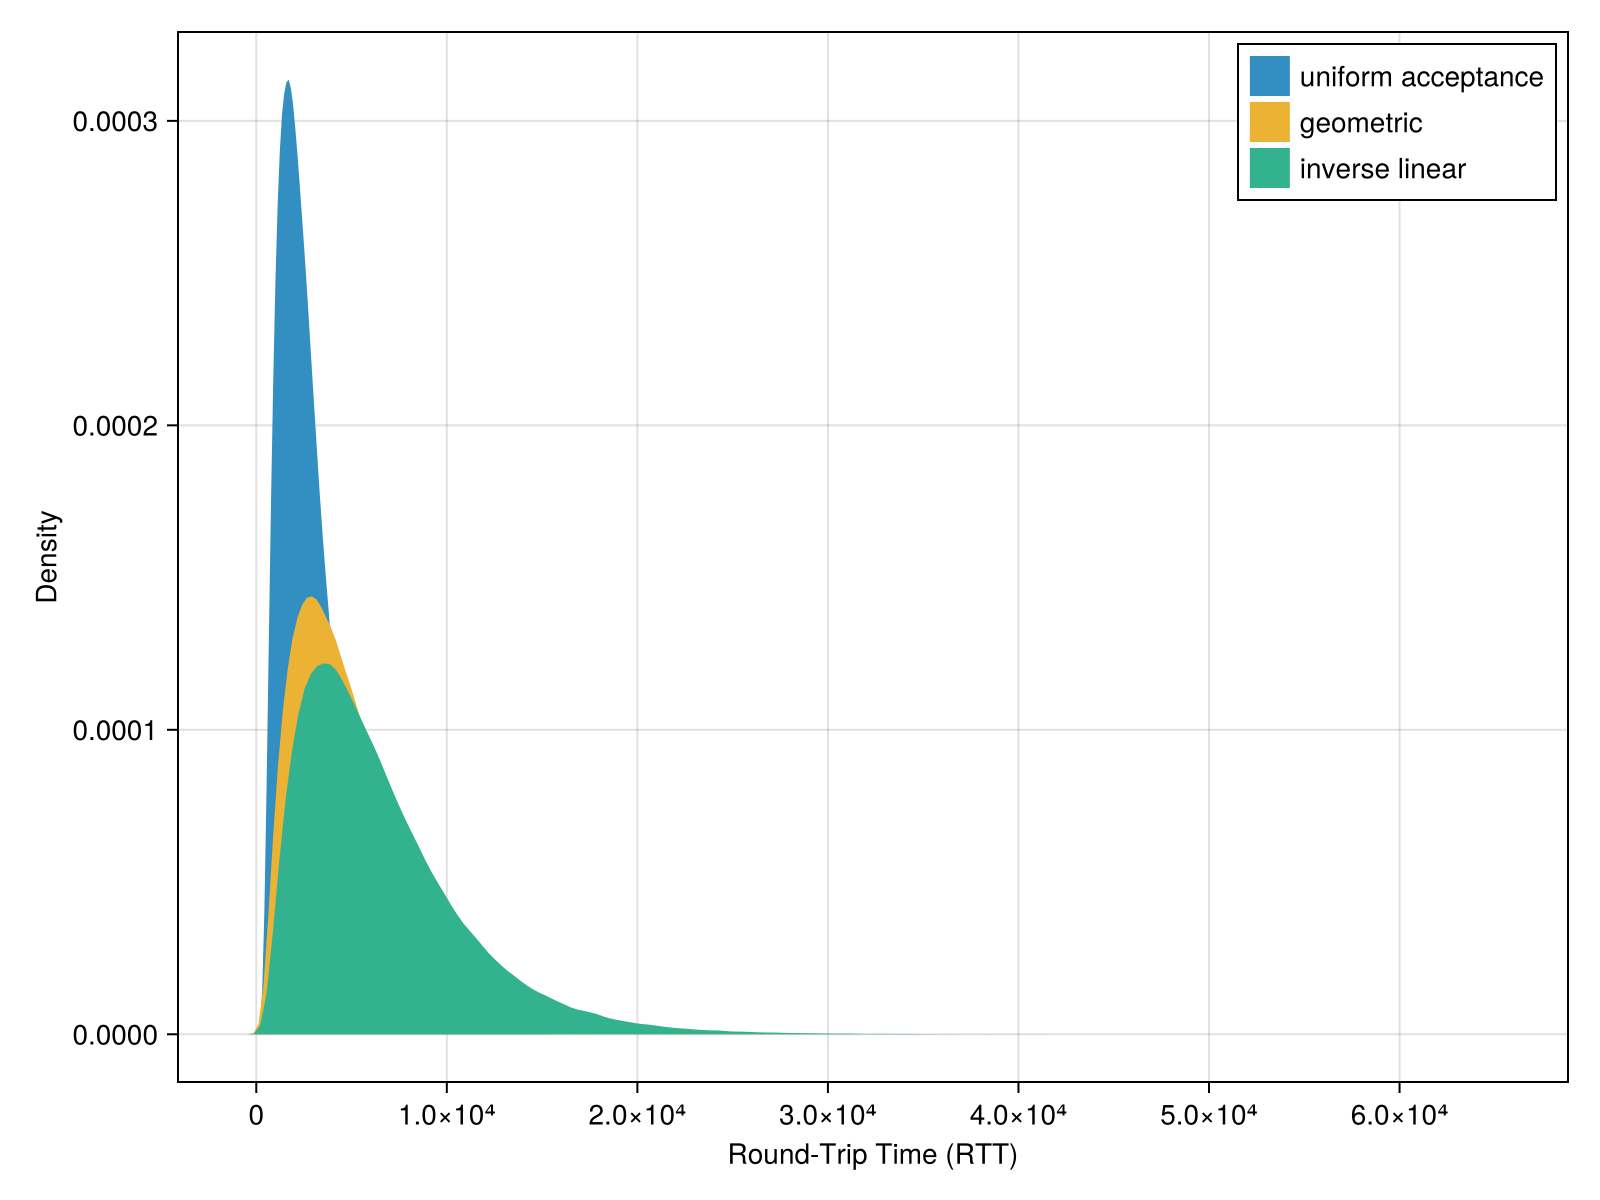

CairoMakie.Screen{IMAGE}


In [5]:
fig = Figure(size=(800, 600))
ax = Axis(fig[1, 1],
    xlabel="Round-Trip Time (RTT)",
    ylabel="Density",
    # title="Distribution of Round-Trip Times for Different Strategies"
)

for strategy in strategys
    if haskey(rtt_results, strategy) && !isempty(rtt_results[strategy])
        density!(ax, rtt_results[strategy], label=strategy)
    else
        println("Warning: No RTT data for strategy '$strategy'. Skipping plot.")
    end
end

axislegend(ax)
display(fig)
# save("rtt_distribution.png", fig)